In [0]:
# Importing libraries.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [0]:
# Mounting at collab.

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Importing more libraries and setting preferences.

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
sns.set_style("darkgrid")


In [0]:
# Reading File.

df_tmp = pd.read_feather('/content/drive/My Drive/nyc_taxi_data_raw.feather')
train = df_tmp.sample(frac=0.05, replace=True, random_state=1)

CPU times: user 1min 1s, sys: 12.3 s, total: 1min 13s
Wall time: 1min 20s


In [0]:
# Saving into feather format, as it loads the same dataframe next time directly, without reading the csv file again!
train = train.drop('index' , axis=1)
del df_tmp

CPU times: user 4.78 s, sys: 63.6 ms, total: 4.84 s
Wall time: 4.84 s


In [0]:
# Creating training dataframe.
df_train = train

# Checking statistics of the features
df_train.describe()

In [0]:
# Counting number of rows which has fare_amount less than zero.

len(df_train[df_train.fare_amount > 0])

11083985

In [0]:
# Since they are less than 300 records which has fare_amount less than zero,
# So we will drop them ( for 2.000.000 rows)

df_train = df_train[df_train.fare_amount>=0]

In [0]:
#Count the number of null value.

df_train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    77
dropoff_latitude     77
passenger_count       0
dtype: int64

In [0]:
#Since the number of null values are not too much, we will drop all the rows with null value.

df_train = df_train.dropna(how = 'any', axis = 'rows')

In [0]:
# Read test data

df_test =  pd.read_csv('/content/drive/My Drive/test.csv')

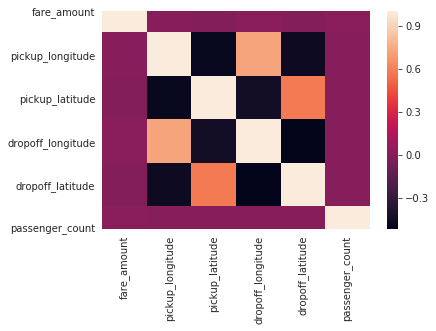

In [0]:
# Timestamp converted to favourabe date format in training data.

df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")
df_train['pickup_datetime']

6762380    2009-08-07 06:10:00
491263     2011-12-10 18:24:54
13419401   2010-03-27 19:52:01
23440075   2012-10-01 09:05:00
26331983   2013-05-25 18:55:00
                   ...        
7347563    2010-03-11 17:40:58
23979439   2011-07-15 08:03:05
38850785   2014-11-12 10:09:38
1542835    2011-11-10 06:39:00
31445022   2010-07-03 17:10:55
Name: pickup_datetime, Length: 11084170, dtype: datetime64[ns]

In [0]:
# Timestamp converted to favourabe date format in test data.

df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")

We will extract more features from Pickup Datetime to hour, day, month, year, day_of_week

In [0]:
# Created a function for extracting hour, day, month, year and week from the date format.

def add_new_date_time_features(dataset):
    dataset['hour'] = dataset.pickup_datetime.dt.hour
    dataset['day'] = dataset.pickup_datetime.dt.day
    dataset['month'] = dataset.pickup_datetime.dt.month
    dataset['year'] = dataset.pickup_datetime.dt.year
    dataset['day_of_week'] = dataset.pickup_datetime.dt.dayofweek
    
    return dataset

In [ ]:
# Applied the above funcyion in both train and test dataset.

df_train = add_new_date_time_features(df_train)
df_test = add_new_date_time_features(df_test)

In [ ]:
# Creating heatmap to view correlation between different features.

target = df_train[['fare_amount']]
df_train['fare_amount'] = target

matrix = df_train.corr()
sns.heatmap(matrix)

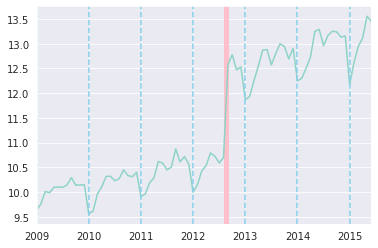

In [0]:
# Fare_amount plotted year wise.

monthly_fare = df_train.groupby(['year', 'month']).fare_amount.mean().reset_index()
monthly_fare.index = pd.to_datetime(monthly_fare.year.astype(str) + '-' + monthly_fare.month.astype(str).str.zfill(2) + '-01')
_ = monthly_fare.fare_amount.plot()
_ = [plt.axvline(pd.to_datetime(m), linestyle='dashed', color='skyblue') for m in monthly_fare.index if m.month==1]
_ = plt.axvspan(pd.to_datetime('2012-08-01'), pd.to_datetime('2012-09-01'), color='pink')

In [0]:
# We observed from above that there was a hike in base fare after Sepetember 2012.
# Therefore a new feature hike_status is added.

df_train['hike_status'] = 0
df_train.loc[(df_train.year >= 2012) & (df_train.month >= 9), 'hike_status'] = 1

df_test['hike_status'] = 0
df_test.loc[(df_test.year >= 2012) & (df_test.month >= 9), 'hike_status'] = 1

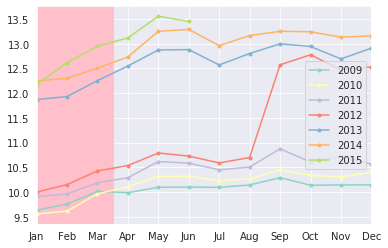

In [0]:
# Fare_amount plotted month wise for each year.

years = [2009, 2010, 2011, 2012, 2013, 2014, 2015]
for y in years:
    year_data = df_train[df_train.year==y].reset_index(drop=True).groupby('month').fare_amount.mean().reset_index()
    year_data.fare_amount.plot.line(marker='.')
_ = plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
_ = plt.axvspan(-0.5, 2.5, color='pink')
_ = plt.legend(years)

In [0]:
# We observed from above that the fares are low on the starting 3 months of each year.
# Therefore a new feature fare_season is added to denote them.

df_train['fare_season'] = 1
df_train.loc[df_train.month <= 3, 'fare_season'] = 0

df_test['fare_season'] = 1
df_test.loc[df_test.month <= 3, 'fare_season'] = 0

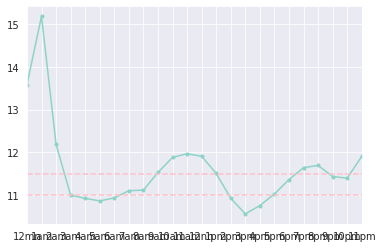

In [0]:
# Fare_amount plotted hour wise.

hourly_fare = df_train.groupby('hour').fare_amount.mean().reset_index()

# UTC time adjustment to NYC (GMT-4)

hourly_fare.hour -= 4
hourly_fare.hour %= 24
hourly_fare = hourly_fare.sort_values('hour').reset_index(drop=True)
_ = hourly_fare.fare_amount.plot.line(marker='.')
hours = ['12mn'] + [str(i) + 'am' for i in range(1,12)] + ['12nn'] + [str(i) + 'pm' for i in range(1,12)]
_ = plt.xticks(range(24), hours)
_ = plt.axhline(11.5, color='pink', linestyle='dashed')
_ = plt.axhline(11, color='pink', linestyle='dashed')

In [0]:
# We observed from above that the fares are high and low on the some specific hours.
# Therefore a new feature hourly_seasonality is added to differentiate them.

hours_high = set([0, 1, 2, 10, 11, 12, 13, 18])
hours_low = set([3, 4, 5, 6, 17, 19, 20])

df_train['hourly_seasonality'] = 1
df_train.loc[(df_train.hour-4).isin(hours_high), 'hourly_seasonality'] = 2
df_train.loc[(df_train.hour-4).isin(hours_low), 'hourly_seasonality'] = 0

df_test['hourly_seasonality'] = 1
df_test.loc[(df_test.hour-4).isin(hours_high), 'hourly_seasonality'] = 2
df_test.loc[(df_test.hour-4).isin(hours_low), 'hourly_seasonality'] = 0


In [0]:
# Limiting the longitude and latitude data with respect to the values of test data.

df_train = df_train[df_train.pickup_longitude.between(df_test.pickup_longitude.min(), df_test.pickup_longitude.max())]
df_train = df_train[df_train.pickup_latitude.between(df_test.pickup_latitude.min(), df_test.pickup_latitude.max())]
df_train = df_train[df_train.dropoff_longitude.between(df_test.dropoff_longitude.min(), df_test.dropoff_longitude.max())]
df_train = df_train[df_train.dropoff_latitude.between(df_test.dropoff_latitude.min(), df_test.dropoff_latitude.max())]

In [0]:
# Checking the size of train data.
df_train.shape

(11084166, 16)

In [0]:
# Extracting distances from the logitudes and latitudes in 3 ways.

## Distance 1: Euclidean Distance
def calculate_abs_different(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    calculate_abs_different(df_train)
    calculate_abs_different(df_test)

    # Converting distances to radians and to miles.
    def convert_different_miles(df):
    df['abs_diff_longitude'] = df.abs_diff_longitude*50
    df['abs_diff_latitude'] = df.abs_diff_latitude*69
    convert_different_miles(df_train)
    convert_different_miles(df_test)
    meas_ang = 0.506

    # Adding extra features for calculation and then deleting the unwanted ones.
    import math
    def add_distance(df):
    df['Euclidean'] = (df.abs_diff_latitude**2 + df.abs_diff_longitude**2)**0.5 ### as the crow flies  
    df['delta_manh_long'] = (df.Euclidean*np.sin(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['delta_manh_lat'] = (df.Euclidean*np.cos(np.arctan(df.abs_diff_longitude / df.abs_diff_latitude)-meas_ang)).abs()
    df['distance'] = df.delta_manh_long + df.delta_manh_lat
    df.drop(['abs_diff_longitude', 'abs_diff_latitude','Euclidean', 'delta_manh_long', 'delta_manh_lat'], axis=1, inplace=True)
    add_distance(df_train)
    add_distance(df_test)
    
    # Extracting direction.
    def calculate_direction(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    
    #Define earth radius (km)
    R_earth = 6371
    
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,[pickup_lat, pickup_lon, dropoff_lat, dropoff_lon])
    
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

    # Converting pandas to numpy to get the best performance
    df_train['direction'] = calculate_direction(df_train['pickup_latitude'].values, df_train['pickup_longitude'].values, 
                                       df_train['dropoff_latitude'].values , df_train['dropoff_longitude'].values) 
    df_test['direction'] = calculate_direction(df_test['pickup_latitude'].values, df_test['pickup_longitude'].values, 
                                       df_test['dropoff_latitude'].values , df_test['dropoff_longitude'].values) 

In [0]:
# Normalize latitude and longitude

df_train['pickup_latitude'].apply(lambda x: np.radians(x))
df_train['pickup_longitude'].apply(lambda x: np.radians(x))
df_train['dropoff_latitude'].apply(lambda x: np.radians(x))
df_train['dropoff_longitude'].apply(lambda x: np.radians(x))

df_test['pickup_latitude'].apply(lambda x: np.radians(x))
df_test['pickup_longitude'].apply(lambda x: np.radians(x))
df_test['dropoff_latitude'].apply(lambda x: np.radians(x))
df_test['dropoff_longitude'].apply(lambda x: np.radians(x))

0          -1.290129
1          -1.291305
2          -1.291243
3          -1.290051
4          -1.291154
              ...   
11084767   -1.291100
11084768   -1.291227
11084769   -1.291123
11084770   -1.289284
11084771   -1.291203
Name: dropoff_longitude, Length: 11084772, dtype: float64

In [0]:
## Distance 2: Haversine Distance

def haversine_distance(lat1, long1, lat2, long2):
    data = [df_train, df_test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

    haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
    df_train.sort_values(['H_Distance','fare_amount'], ascending=False)
    high_distance = df_train.loc[(df_train['H_Distance']>200)&(df_train['fare_amount']!=0)]
    high_distance['H_Distance'] = high_distance.apply(
        lambda row: (row['fare_amount'] - 2.50)/1.56,
        axis=1
    )
    df_train = df_train.drop(df_train[(df_train['H_Distance']==0)&(df_train['fare_amount']==0)].index, axis = 0)
    weekends = df_train.loc[((df_train['day_of_week']==0) | (df_train['day_of_week']==6)) & (df_train['H_Distance']==0) & (df_train['fare_amount'] < 3.0)]
    weekends

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,day_of_week,hike_status,fare_season,hourly_seasonality,distance,direction,holiday_or_not,H_Distance
33936927,2009-10-19 10:04:00.00000062,2.5,2009-10-19 10:04:00,-73.776780,40.645143,-73.776780,40.645143,1,10,19,10,2009,0,0,1,0,NaN,0.0,0,0.0
22879791,2010-10-10 22:00:00.000000121,2.9,2010-10-10 22:00:00,-73.978415,40.684400,-73.978415,40.684400,1,22,10,10,2010,6,0,1,2,NaN,0.0,0,0.0
34297531,2013-08-11 18:29:00.00000052,2.5,2013-08-11 18:29:00,0.000000,0.000000,0.000000,0.000000,6,18,11,8,2013,6,0,1,1,NaN,0.0,0,0.0
14537399,2009-12-07 15:04:46.0000002,2.5,2009-12-07 15:04:46,-73.977696,40.761911,-73.977696,40.761911,1,15,7,12,2009,0,0,1,2,NaN,0.0,0,0.0
22472784,2009-04-19 00:24:50.0000009,2.5,2009-04-19 00:24:50,-73.952237,40.777520,-73.952237,40.777520,1,0,19,4,2009,6,0,1,1,NaN,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10278055,2014-09-15 16:42:00.000000115,2.5,2014-09-15 16:42:00,0.000000,0.000000,0.000000,0.000000,1,16,15,9,2014,0,1,1,2,NaN,0.0,0,0.0
12874819,2009-10-12 14:39:00.00000088,2.5,2009-10-12 14:39:00,-73.972737,40.780810,-73.972737,40.780810,1,14,12,10,2009,0,0,1,2,NaN,0.0,0,0.0
26025354,2014-11-24 14:40:57.0000005,2.5,2014-11-24 14:40:57,-73.953072,40.736295,-73.953072,40.736295,1,14,24,11,2014,0,1,1,2,NaN,0.0,0,0.0
40020058,2009-04-27 22:49:30.0000003,2.5,2009-04-27 22:49:30,-73.983135,40.730865,-73.983135,40.730865,3,22,27,4,2009,0,0,1,2,NaN,0.0,0,0.0


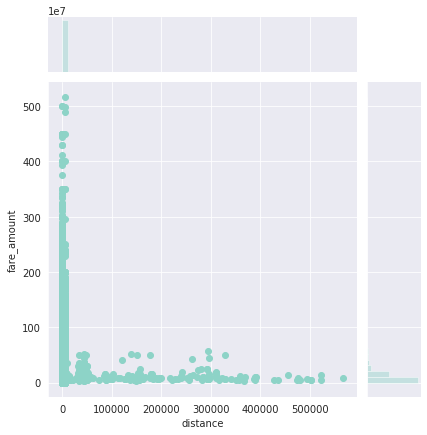

In [0]:
## Distance 3: Manhattan Distance

    def minkowski_distance(x1, x2, y1, y2, p):
      return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

    df_train['manhattan'] = minkowski_distance(df_train['pickup_longitude'], df_train['dropoff_longitude'],
                                           df_train['pickup_latitude'], df_train['dropoff_latitude'], 1)
    df_test['manhattan'] = minkowski_distance(df_test['pickup_longitude'], df_test['dropoff_longitude'],
                                           df_test['pickup_latitude'], df_test['dropoff_latitude'], 1)
    sns.jointplot(x='distance', y='fare_amount', data=df_train)

In [0]:
# Viewing all the features in dataset.

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11084109 entries, 6762380 to 31445022
Data columns (total 21 columns):
key                   object
fare_amount           float64
pickup_datetime       datetime64[ns]
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count       int64
hour                  int64
day                   int64
month                 int64
year                  int64
day_of_week           int64
hike_status           int64
fare_season           int64
hourly_seasonality    int64
distance              float64
direction             float64
holiday_or_not        int64
H_Distance            float64
manhattan             float64
dtypes: datetime64[ns](1), float64(9), int64(10), object(1)
memory usage: 1.8+ GB


In [0]:
# Since we extracted feature with day, week, month, year so we can remove 'pickup_datetime' feature.

df_train.drop(columns=['pickup_datetime'], inplace=True)

y = df_train['fare_amount']
df_train = df_train.drop(columns=['fare_amount'])

In [0]:
# Modeling with model 'lightgbm'.

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
df_train = df_train.drop('key' , axis=1)
x_train,x_test,y_train,y_test = train_test_split(df_train,y,random_state=123,test_size=0.1)

In [0]:
# Parameters to be used in lightgbm model.

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 10000 ,
        'bagging_freq': 10,
        'metric': 'rmse',  
        'zero_as_missing': True,
    }

In [0]:
# Setting up the number of boosting iterations and other parameters of lightgbm.

train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=['day_of_week','hike_status','fare_season','hourly_seasonality'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=['day_of_week','hike_status','fare_season','hourly_seasonality'])
model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=1000,verbose_eval=500, valid_sets=valid_set)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 1000 rounds.
[500]	valid_0's rmse: 3.98458
[1000]	valid_0's rmse: 3.94021
[1500]	valid_0's rmse: 3.91778
[2000]	valid_0's rmse: 3.90108
[2500]	valid_0's rmse: 3.88986
[3000]	valid_0's rmse: 3.8802
[3500]	valid_0's rmse: 3.87175
[4000]	valid_0's rmse: 3.86453
[4500]	valid_0's rmse: 3.85981
[5000]	valid_0's rmse: 3.85409
[5500]	valid_0's rmse: 3.84921
[6000]	valid_0's rmse: 3.84413
[6500]	valid_0's rmse: 3.84029
[7000]	valid_0's rmse: 3.83644
[7500]	valid_0's rmse: 3.83262
[8000]	valid_0's rmse: 3.82993
[8500]	valid_0's rmse: 3.82725
[9000]	valid_0's rmse: 3.82493
[9500]	valid_0's rmse: 3.82236
[10000]	valid_0's rmse: 3.8197
Did not meet early stopping. Best iteration is:
[9997]	valid_0's rmse: 3.81969


In [0]:
# Dropping the feature 'key' as we don't need it for prediction.
# Dropping the feature 'pickup_datetime' as we have extracted its information before and it is not required.

test_key = df_test['key']
df_test.drop(columns=["pickup_datetime",'key'], axis=1, inplace=True)

In [0]:
# Predicting the outcomes.

prediction = model.predict(df_test, num_iteration = model.best_iteration)      

In [0]:
#Code for submission.

submission = pd.DataFrame({
        "key": test_key,
        "fare_amount": prediction
})

submission.to_csv('taxi_fare_submissionlgbm.csv',index=False)